<a href="https://colab.research.google.com/github/chandramohan0/DeepLearningProject/blob/main/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1XIWJoSWq0fNo6xHNOcHr00CM7rkwdYdF')

     |████████████████████████████████| 71kB 7.7MB/s 


In [2]:
!pip install jovian --upgrade --quiet

# Identifying Flower Species using Deep Learning and PyTorch

 ##  Todo -  **Introduction**

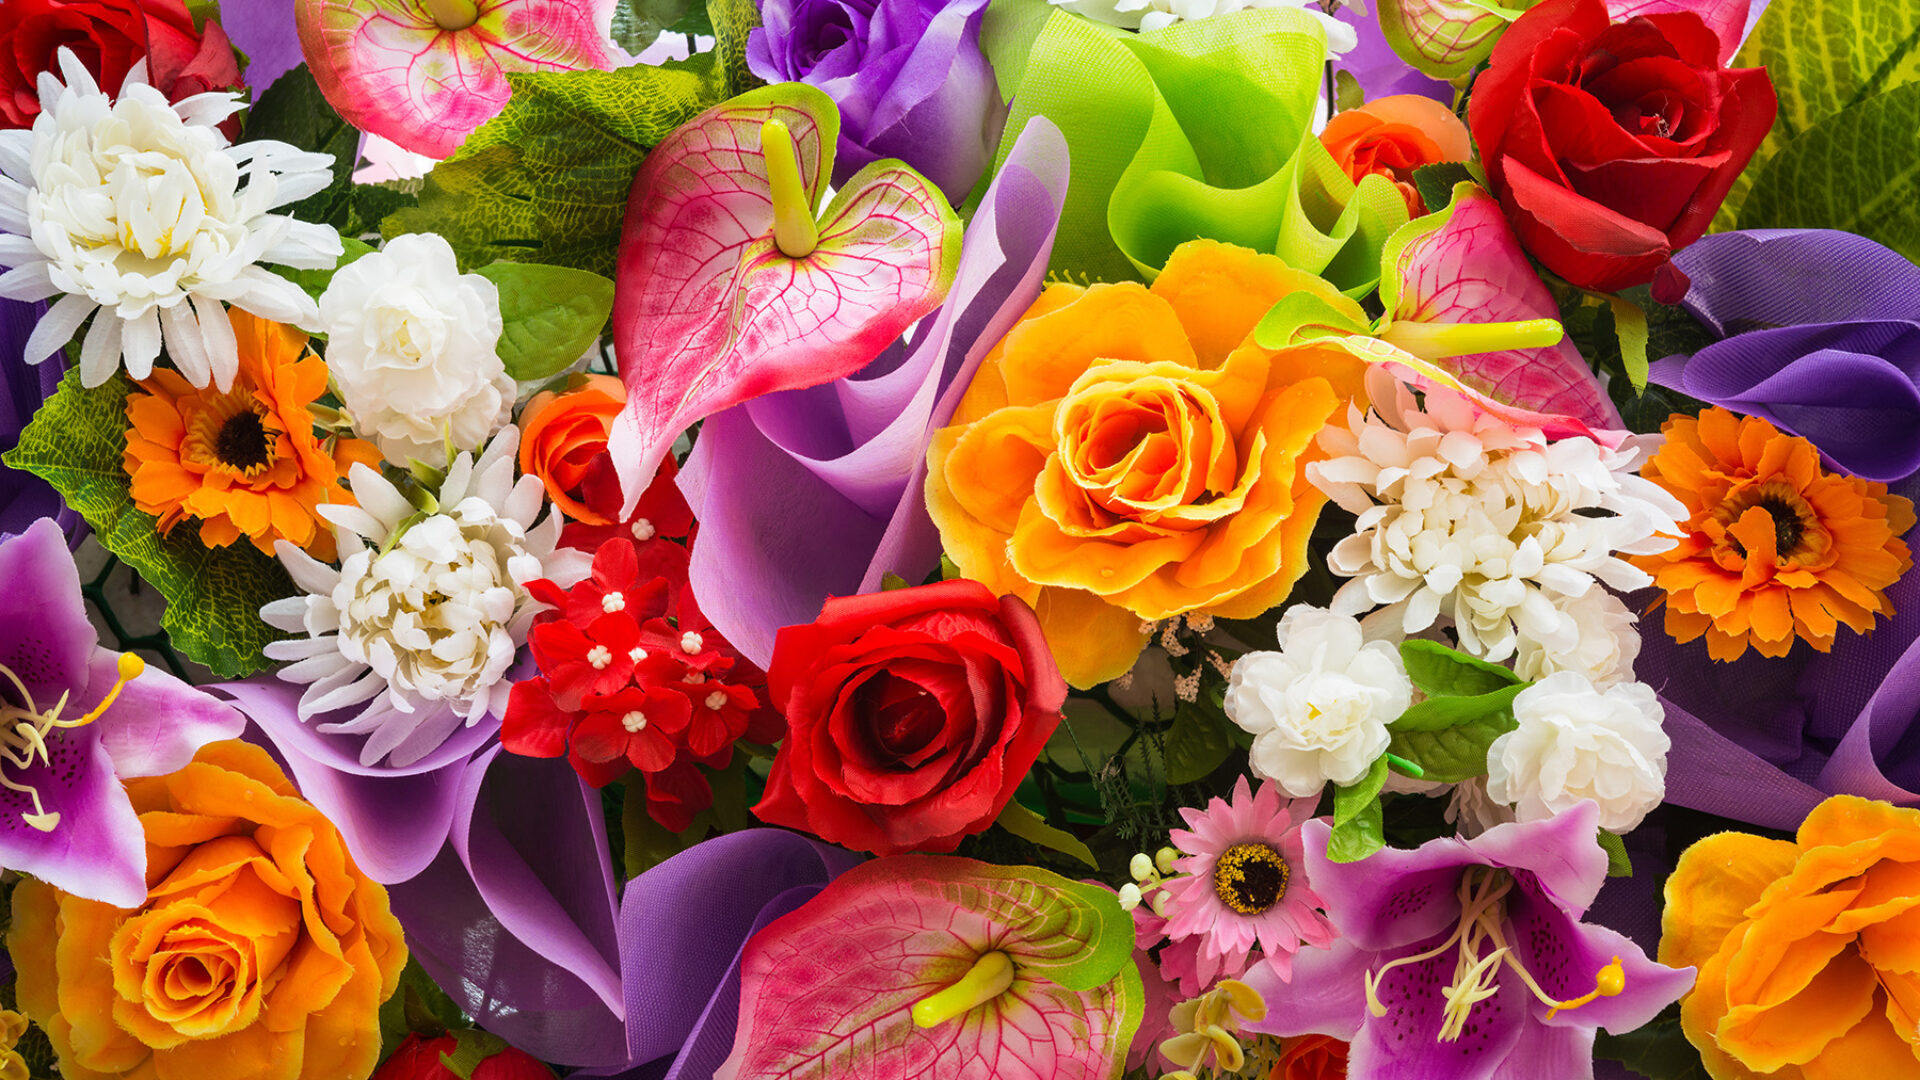


We are going to do it in the following steps:-

1. Pick a dataset
2. Download the dataset
3. Import the dataset using PyTorch
4. Explore the dataset.
5. Prepare the dataset for training
6. Move the dataset to the GPU.
7. Define a neural networks.
8. Train the model.
9. Make predictions on sample images.

Iterate on it with different networks & hyperparameters. 

### Download the Dataset

Using 'opendatasets' and download the dataset from https://www.kaggle.com/alxmamaev/flowers-recognition .


In [3]:
!pip install opendatasets --upgrade

In [4]:
import opendatasets as od

In [5]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [6]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
  shutil.rmtree('./flowers-recognition')

In [7]:
od.download('https://www.kaggle.com/alxmamaev/flowers-recognition')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chandramohan01
Your Kaggle Key: ··········


  2%|▏         | 10.0M/450M [00:00<00:04, 100MB/s]

100%|██████████| 450M/450M [00:03<00:00, 138MB/s]


In [8]:
data_dir = './flowers-recognition/flowers'

In [9]:
import os

In [10]:
os.listdir(data_dir)

['sunflower', 'flowers', 'rose', 'daisy', 'dandelion', 'tulip']

In [11]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [12]:
os.listdir(data_dir)

['sunflower', 'rose', 'daisy', 'dandelion', 'tulip']

In [13]:
for cls in os.listdir(data_dir):
  print(cls,':',len(os.listdir(data_dir + '/' + cls)))

sunflower : 734
rose : 784
daisy : 769
dandelion : 1055
tulip : 984


In [14]:
!pip install jovian --quiet

In [15]:
import jovian

In [16]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/thechandramohan01/deep-learning-project


'https://jovian.ai/thechandramohan01/deep-learning-project'

### **Import the dataset into PyTorch**

Use the 'ImageFolder' class from 'torchvision'.

In [17]:
from torchvision.datasets import ImageFolder

In [18]:
dataset = ImageFolder(data_dir)

In [19]:
len(dataset)

4323

In [20]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FCA36242908>, 0)

In [21]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

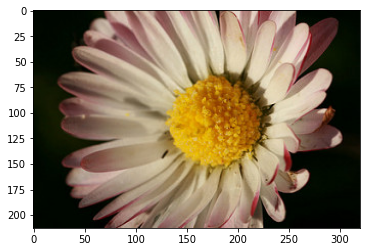

In [23]:
img, label = dataset[150]
plt.imshow(img)

In [24]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

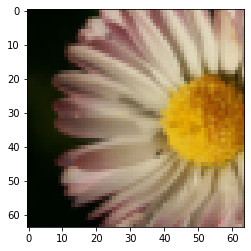

In [25]:
img, label = dataset[150]
plt.imshow(img.permute((1,2,0)))

In [26]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [27]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(valid_ds)

(3891, 432)

In [28]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

In [29]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

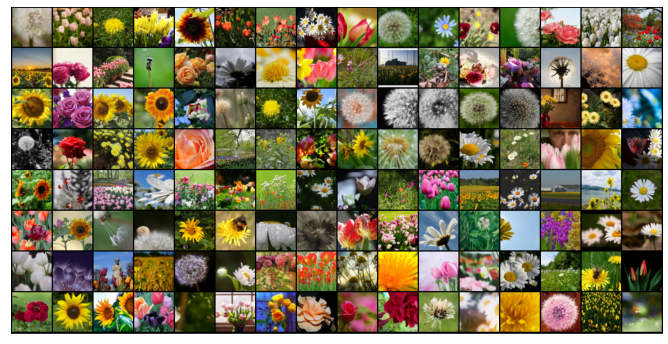

In [30]:
show_batch(train_dl)

## **GPU Utilities**

In [31]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
torch.cuda.is_available()

True

In [33]:
device = get_default_device()

In [34]:
device

device(type='cuda')

In [35]:
img, label = dataset[0]

In [36]:
img.shape

torch.Size([3, 64, 64])

In [37]:
img.device

device(type='cpu')

In [38]:
img_gpu = to_device(img,device)
img_gpu.device

device(type='cuda', index=0)

In [39]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### **Model and Trainig Utilities**

In [40]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      "calculate loss for a batch of training data"
      images, labels = batch 
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      return loss
    
    def validation_step(self, batch):
      "calculate loss & accuracy for a batch of validation data"
      images, labels = batch 
      out = self(images)                    # Generate predictions
      loss = F.cross_entropy(out, labels)   # Calculate loss
      acc = accuracy(out, labels)           # Calculate accuracy
      return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
@torch.no_grad()
def evaluate(model, val_loader):

  """Evaluates the model's performance on the validation set"""
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
!pip install jovian --quiet

In [43]:
import jovian

In [44]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/thechandramohan01/deep-learning-project


'https://jovian.ai/thechandramohan01/deep-learning-project'

### Model

In [45]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #INPUTS : 128 * 3 * 64 * 64
        self.conv1 = conv_block(in_channels, 64) # 128*64*64*64
        self.conv2 = conv_block(64, 128, pool=True)# 128*128*32*32
        self.res1 = nn.Sequential(conv_block(128, 128),# 128*128*32*32
                                  conv_block(128, 128))# 128*128*32*32
        
        self.conv3 = conv_block(128, 256, pool=True)#128*256*16*16
        self.conv4 = conv_block(256, 512, pool=True)#128*512*8*8
        self.res2 = nn.Sequential(conv_block(512, 512),#128*512*8*8
                                  conv_block(512, 512))#128*512*8*8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), #128*512*1*1
                                        nn.Flatten(), #128*512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [46]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [47]:
model.conv1[0].weight.device

device(type='cuda', index=0)

### Pass one batch of input tensor through the model

In [48]:
torch.cuda.empty_cache()
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape',preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


In [49]:
!pip install jovian --quiet

In [50]:
import jovian

In [51]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/thechandramohan01/deep-learning-project


'https://jovian.ai/thechandramohan01/deep-learning-project'

### Training Model

In [52]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2903645932674408, 'val_loss': 1.6063982248306274}]

In [53]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3704, val_loss: 1.5380, val_acc: 0.3958
Epoch [1], train_loss: 0.9247, val_loss: 0.9153, val_acc: 0.6322
Epoch [2], train_loss: 0.8396, val_loss: 0.9760, val_acc: 0.6367
Epoch [3], train_loss: 0.7427, val_loss: 0.7691, val_acc: 0.7396
Epoch [4], train_loss: 0.6722, val_loss: 1.0869, val_acc: 0.6432


In [54]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8783, val_loss: 0.7216, val_acc: 0.7174
Epoch [1], train_loss: 0.6742, val_loss: 1.1099, val_acc: 0.6100
Epoch [2], train_loss: 0.6014, val_loss: 0.5743, val_acc: 0.8053
Epoch [3], train_loss: 0.5351, val_loss: 0.8227, val_acc: 0.6784
Epoch [4], train_loss: 0.5012, val_loss: 0.8088, val_acc: 0.7240


In [55]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.5347, val_loss: 0.6248, val_acc: 0.7897
Epoch [1], train_loss: 0.4506, val_loss: 0.8261, val_acc: 0.6914
Epoch [2], train_loss: 0.3868, val_loss: 0.5039, val_acc: 0.8190
Epoch [3], train_loss: 0.3705, val_loss: 0.7295, val_acc: 0.7650
Epoch [4], train_loss: 0.3432, val_loss: 0.7090, val_acc: 0.7812


In [56]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4026, val_loss: 0.5059, val_acc: 0.8210
Epoch [1], train_loss: 0.2823, val_loss: 0.8024, val_acc: 0.7402
Epoch [2], train_loss: 0.2912, val_loss: 0.6069, val_acc: 0.8079
Epoch [3], train_loss: 0.2814, val_loss: 0.5164, val_acc: 0.8392
Epoch [4], train_loss: 0.2537, val_loss: 0.6687, val_acc: 0.7695


In [57]:
history += fit(5, 0.001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.1848, val_loss: 0.3992, val_acc: 0.8620
Epoch [1], train_loss: 0.1713, val_loss: 0.4058, val_acc: 0.8665
Epoch [2], train_loss: 0.1602, val_loss: 0.4188, val_acc: 0.8529
Epoch [3], train_loss: 0.1533, val_loss: 0.3777, val_acc: 0.8672
Epoch [4], train_loss: 0.1604, val_loss: 0.4020, val_acc: 0.8685


In [58]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

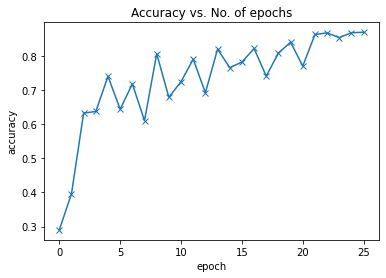

In [59]:
plot_accuracies(history)

In [60]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

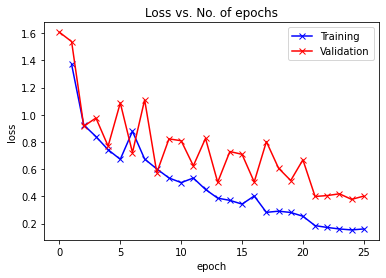

In [61]:
plot_losses(history)

## Record the Results

In [62]:
history[-1]

{'train_loss': 0.16038267314434052,
 'val_acc': 0.8684895634651184,
 'val_loss': 0.4019637107849121}

In [63]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128,
                       arch='ResNet9',
                       epochs=[5,5,5,5,5], 
                        lrs=[0.001,0.001,1e-4,1e-4],
                       opt=['Adam','Adam','Adam','Adam','SGD'])

jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [64]:
jovian.commit(project='deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/thechandramohan01/deep-learning-project


'https://jovian.ai/thechandramohan01/deep-learning-project'

### **Test With Individual Images**

In [65]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [66]:
def show_image_prediction(img,label):
  plt.imshow(img.permute((1,2,0)))
  pred= predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)


Target: daisy
Prediction: daisy


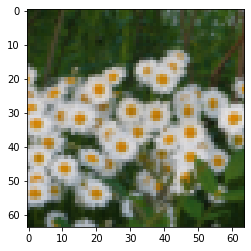

In [67]:
show_image_prediction(*valid_ds[51])

Target: daisy
Prediction: daisy


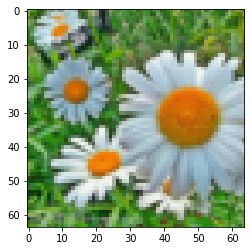

In [75]:
show_image_prediction(*valid_ds[305])

Target: rose
Prediction: rose


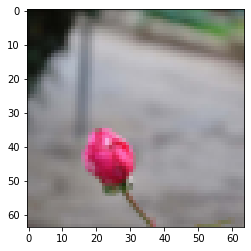

In [76]:
show_image_prediction(*valid_ds[125])

Target: daisy
Prediction: daisy


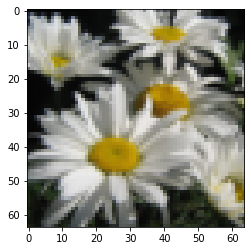

In [77]:
show_image_prediction(*valid_ds[11])

Target: daisy
Prediction: daisy


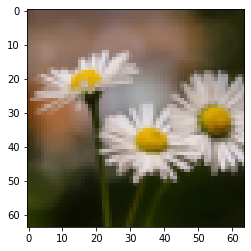

In [78]:
show_image_prediction(*valid_ds[25])

Target: sunflower
Prediction: sunflower


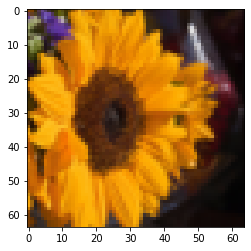

In [79]:
show_image_prediction(*valid_ds[61])

In [80]:
torch.save(model.state_dict(),'flowers-resnet9.pth')

In [81]:
jovian.commit(project='deep-learning-project',
              outputs=['flowers-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/thechandramohan01/deep-learning-project


'https://jovian.ai/thechandramohan01/deep-learning-project'